<a href="https://colab.research.google.com/github/oleeejka/Google-Colab/blob/main/my_mnist_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

from tqdm import tqdm

**1. Работа с данными**

Задаём трансформацию в тензор

In [ ]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

Загружаем датасет, применяем трансформацию

In [ ]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform=trans)

Выведем изображение первой цифры

In [ ]:
ds_mnist[0][0].numpy()[0].shape

(28, 28)

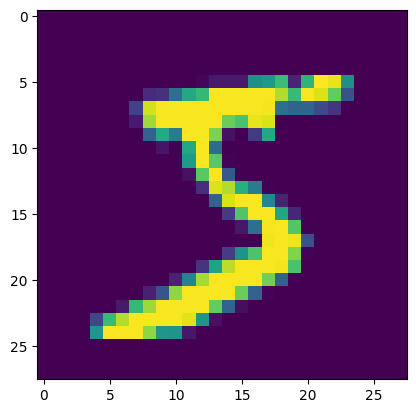

In [ ]:
plt.imshow(ds_mnist[0][0].numpy()[0])

**2. Dataloader**

In [ ]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(
    ds_mnist, batch_size=batch_size, shuffle=True, drop_last=True
)

In [ ]:
for img, label in dataloader:
  print(img.shape) ## batches, canals, height, weidth
  print(label.shape) ## num of labels
  break

torch.Size([16, 1, 28, 28])
torch.Size([16])


**3. Архитектура НС**

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.flat = nn.Flatten() ## развернуть фото в вектор
    self.linear1 = nn.Linear(28*28, 100)
    self.act1 = nn.ReLU()
    self.linear2 = nn.Linear(100, 10)
    # self.act2 = nn.Softmax(dim=1)

    ## self.model = nn.Sequential(linear1, act1, linear2, act2)

  def forward(self, x): ## forward - как перемещаются тензоры по НС
    x = self.flat(x)
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    # x = self.act2(x)
    return x

In [ ]:
model = Net() ## create a model

**3. Loss function**

In [ ]:
loss_fn = nn.CrossEntropyLoss()


**4. Optimizer**

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
## посмотрим кол-во параметров в НС

total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров: {total_params}")

Общее количество параметров: 79510


**5. Обучение**

**Accuracy**

In [ ]:
def accuracy(pred, label):
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  ## nn.Softmax(pred.detach()).argmax позволяет узнать результат работы НС
  return answer.mean()



In [ ]:
epochs = 10

for epoch in range(epochs):
  loss_val = 0
  acc_val = 0 ## accuracy
  for img, label in (pbar := tqdm(dataloader)):

    label = nn.functional.one_hot(label, 10).float()
    pred = model(img)

    loss = loss_fn(pred, label)
    loss_val += loss.item()

    acc_current = accuracy(pred, label) ## для простоты проверяем все на train
    acc_val += acc_current
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(f'loss: {loss.item():.4f}\taccuracy: {acc_current:.3f}') ## визуализация лосса

  print(loss_val / len(dataloader)) ## mean loss after each epoch
  print(acc_val / len(dataloader)) ## mean accuracy after each epoch

  0%|          | 0/3750 [00:00<?, ?it/s]<ipython-input-195-b34466c008b5>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 1.2049	accuracy: 0.875: 100%|██████████| 3750/3750 [00:43<00:00, 86.32it/s]


1.8366222496350606
0.0


loss: 0.6103	accuracy: 0.875: 100%|██████████| 3750/3750 [00:47<00:00, 79.18it/s]


0.941645849609375
0.0


loss: 0.4867	accuracy: 0.875: 100%|██████████| 3750/3750 [00:38<00:00, 96.18it/s]


0.6241251037200292
0.0


loss: 0.4575	accuracy: 0.875: 100%|██████████| 3750/3750 [00:39<00:00, 94.54it/s] 


0.5072802192012469
0.0


loss: 0.3148	accuracy: 0.938: 100%|██████████| 3750/3750 [00:41<00:00, 90.31it/s]


0.44784501155813533
0.0


loss: 0.3649	accuracy: 0.875: 100%|██████████| 3750/3750 [00:39<00:00, 95.07it/s]


0.41217484800219534
0.0


loss: 1.0112	accuracy: 0.750: 100%|██████████| 3750/3750 [00:40<00:00, 92.31it/s]


0.38784701143006484
0.0


loss: 0.1739	accuracy: 0.938: 100%|██████████| 3750/3750 [00:38<00:00, 96.20it/s]


0.3700619765097896
0.0


loss: 0.3147	accuracy: 0.875: 100%|██████████| 3750/3750 [00:41<00:00, 89.38it/s]


0.3562695203483105
0.0


loss: 0.2223	accuracy: 1.000: 100%|██████████| 3750/3750 [00:39<00:00, 95.82it/s]

0.34495752425988513
0.0


**Проверим НС на новых данных**

Загружаем картинку

In [ ]:
img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
img.shape

(28, 28)

In [ ]:
## добавляем вначале ещё одну размерность - один канал. Должно стать (1, 28, 28)
## делаем это дважды, т.к. наша НС работает с (1, 1, 28, 28)
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32) / 255.0

In [ ]:
img.shape

(1, 1, 28, 28)

Переводим картинку в тензор, получаем предсказание модели

In [ ]:
t_img = torch.from_numpy(img)
nash_pred = model(t_img)

In [ ]:
F.softmax(nash_pred).detach().numpy().argmax()

<ipython-input-202-15d07e92809c>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(nash_pred).detach().numpy().argmax()


5